# BASIC REGRESION: DELIVERY TIME ESTIMATION

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from keras import layers, regularizers, Input
from keras.callbacks import EarlyStopping


print(tf.__version__)

2.16.1


In [3]:
data_path = '/kaggle/input/porter-delivery-time-estimation/dataset.csv'

raw_dataset = pd.read_csv(data_path)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,c81e155d85dae5430a8cee6f2242e82c,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0
197427,1.0,2015-02-08 19:24:33,2015-02-08 20:01:41,c81e155d85dae5430a8cee6f2242e82c,sandwich,1.0,4,2605,4,425,750,20.0,20.0,23.0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

### Clean the data

In [6]:
dataset.isna().sum()

market_id                     987
created_at                      0
actual_delivery_time            7
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [7]:
dataset = dataset.dropna()

In [8]:
dataset['created_at'] = pd.to_datetime(dataset['created_at'])
dataset.rename(columns={'created_at' : 'order_date'}, inplace=True)

# Extract features
dataset['order_year'] = dataset['order_date'].dt.year
dataset['order_month'] = dataset['order_date'].dt.month
dataset['order_day'] = dataset['order_date'].dt.day
dataset['order_dow'] = dataset['order_date'].dt.dayofweek
dataset['order_hour'] = dataset['order_date'].dt.hour

# Cyclical encoding for month, day of week, and hour
dataset['order_month_sin'] = np.sin(dataset['order_month'] * (2 * np.pi / 12))
dataset['order_month_cos'] = np.cos(dataset['order_month'] * (2 * np.pi / 12))
dataset['order_dow_sin'] = np.sin(dataset['order_dow'] * (2 * np.pi / 7))
dataset['order_dow_cos'] = np.cos(dataset['order_dow'] * (2 * np.pi / 7))
dataset['order_hour_sin'] = np.sin(dataset['order_hour'] * (2 * np.pi / 24))
dataset['order_hour_cos'] = np.cos(dataset['order_hour'] * (2 * np.pi / 24))

# Unix timestamp
dataset['timestamp'] = dataset['order_date'].astype('int64') // 10**9

In [9]:
dataset['actual_delivery_time'] = pd.to_datetime(dataset['actual_delivery_time'])

# En vez de predecir la fecha y hora, predecir el tiempo que se tardará la orden y con eso inferir.
dataset['ETD'] = (dataset['actual_delivery_time'] - dataset['order_date']).dt.total_seconds() // 60
dataset.drop([
    'store_id', # Variable Categorica... No tiene caso hacer un modelo por tienda
    'actual_delivery_time', # No podemos entrenar directamente con la fecha
    'order_date', # No podemos entrenar directamente con la fecha
    'order_year', # Todo lo estamos trabajando en 2015... no tiene sentido esta variable.
    'order_month', # Ya la tenemos transformada con su seno y coseno
    'order_dow', # Lo mismo que para mes
    'order_hour', # Lo mismo que para mes
], inplace=True,axis=1)

In [10]:
# Target Encoding
category_means = dataset.groupby('store_primary_category')['ETD'].mean().to_dict()
dataset['store_primary_category'] = dataset['store_primary_category'].map(category_means)

market_means = dataset.groupby('market_id')['ETD'].mean().to_dict()
dataset['market_id'] = dataset['market_id'].map(market_means)

protocol_means = dataset.groupby('order_protocol')['ETD'].mean().to_dict()
dataset['order_protocol'] = dataset['order_protocol'].map(protocol_means)

In [11]:
dataset.tail()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,order_day,order_month_sin,order_month_cos,order_dow_sin,order_dow_cos,order_hour_sin,order_hour_cos,timestamp,ETD
197423,51.012336,43.288411,47.663255,3,1389,3,345,649,17.0,17.0,23.0,17,0.866025,0.500000,0.781831,0.623490,0.000000,1.000000e+00,1424132381,65.0
197424,51.012336,43.288411,47.663255,6,3010,4,405,825,12.0,11.0,14.0,13,0.866025,0.500000,-0.433884,-0.900969,0.000000,1.000000e+00,1423785719,56.0
197425,51.012336,43.288411,47.663255,5,1836,3,300,399,39.0,41.0,40.0,24,0.500000,0.866025,-0.974928,-0.222521,0.866025,5.000000e-01,1422074768,50.0
197426,51.012336,43.586779,49.540727,1,1175,1,535,535,7.0,7.0,12.0,1,0.866025,0.500000,-0.781831,0.623490,-1.000000,-1.836970e-16,1422814695,65.0
197427,51.012336,43.586779,49.540727,4,2605,4,425,750,20.0,20.0,23.0,8,0.866025,0.500000,-0.781831,0.623490,-0.965926,2.588190e-01,1423423473,37.0


In [12]:
dataset.describe()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,order_day,order_month_sin,order_month_cos,order_dow_sin,order_dow_cos,order_hour_sin,order_hour_cos,timestamp,ETD
count,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,1.762480e+05,176248.000000
mean,47.271992,47.271992,47.271992,3.204592,2696.498939,2.674589,684.937730,1159.886994,44.905276,41.845434,58.206800,15.397429,0.736668,0.629357,-0.092407,0.007192,0.067385,0.675208,1.423079e+09,47.271992
std,2.015352,2.544539,1.875059,2.673899,1828.922584,1.625558,519.911425,560.784510,34.529394,32.154573,52.708344,9.234376,0.174971,0.174971,0.710567,0.697502,0.658821,0.324825,6.946565e+05,27.656174
min,45.542583,34.000000,40.894737,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,1.000000,0.500000,0.500000,-0.974928,-0.900969,-1.000000,-0.866025,1.421854e+09,1.000000
25%,45.542583,44.719455,46.562417,2.000000,1408.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,7.000000,0.500000,0.500000,-0.781831,-0.900969,-0.707107,0.500000,1.422495e+09,35.000000
50%,46.871050,47.382703,46.562417,3.000000,2221.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,14.000000,0.866025,0.500000,0.000000,-0.222521,0.258819,0.707107,1.423103e+09,44.000000
75%,46.940101,49.793063,49.540727,4.000000,3407.000000,3.000000,942.000000,1395.000000,65.000000,62.000000,85.000000,24.000000,0.866025,0.866025,0.433884,0.623490,0.707107,0.965926,1.423702e+09,56.000000
max,51.012336,55.902439,62.684288,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,31.000000,0.866025,0.866025,0.974928,1.000000,1.000000,1.000000,1.424239e+09,6231.000000


### Remove Outliers
Los valores atípicos pueden sesgar nuestro modelo. Hay que o reemplazarlos o quitarlos.

In [13]:
alpha = 0.05

# lower_bound = dataset.quantile(alpha)
lower_bound = dataset.quantile(0)
upper_bound = dataset.quantile(1 - alpha)
mask = (dataset >= lower_bound) & (dataset <= upper_bound)
dataset_filtered = dataset[mask.all(axis=1)]

In [14]:
dataset_filtered.shape, dataset.shape

((114353, 20), (176248, 20))

In [15]:
dataset = dataset_filtered.reset_index()

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [16]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

In [17]:
train_dataset.shape, test_dataset.shape

((91482, 21), (22871, 21))

In [18]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91482 entries, 43241 to 610
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     91482 non-null  int64  
 1   market_id                 91482 non-null  float64
 2   store_primary_category    91482 non-null  float64
 3   order_protocol            91482 non-null  float64
 4   total_items               91482 non-null  int64  
 5   subtotal                  91482 non-null  int64  
 6   num_distinct_items        91482 non-null  int64  
 7   min_item_price            91482 non-null  int64  
 8   max_item_price            91482 non-null  int64  
 9   total_onshift_partners    91482 non-null  float64
 10  total_busy_partners       91482 non-null  float64
 11  total_outstanding_orders  91482 non-null  float64
 12  order_day                 91482 non-null  int32  
 13  order_month_sin           91482 non-null  float64
 14  order_mon

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

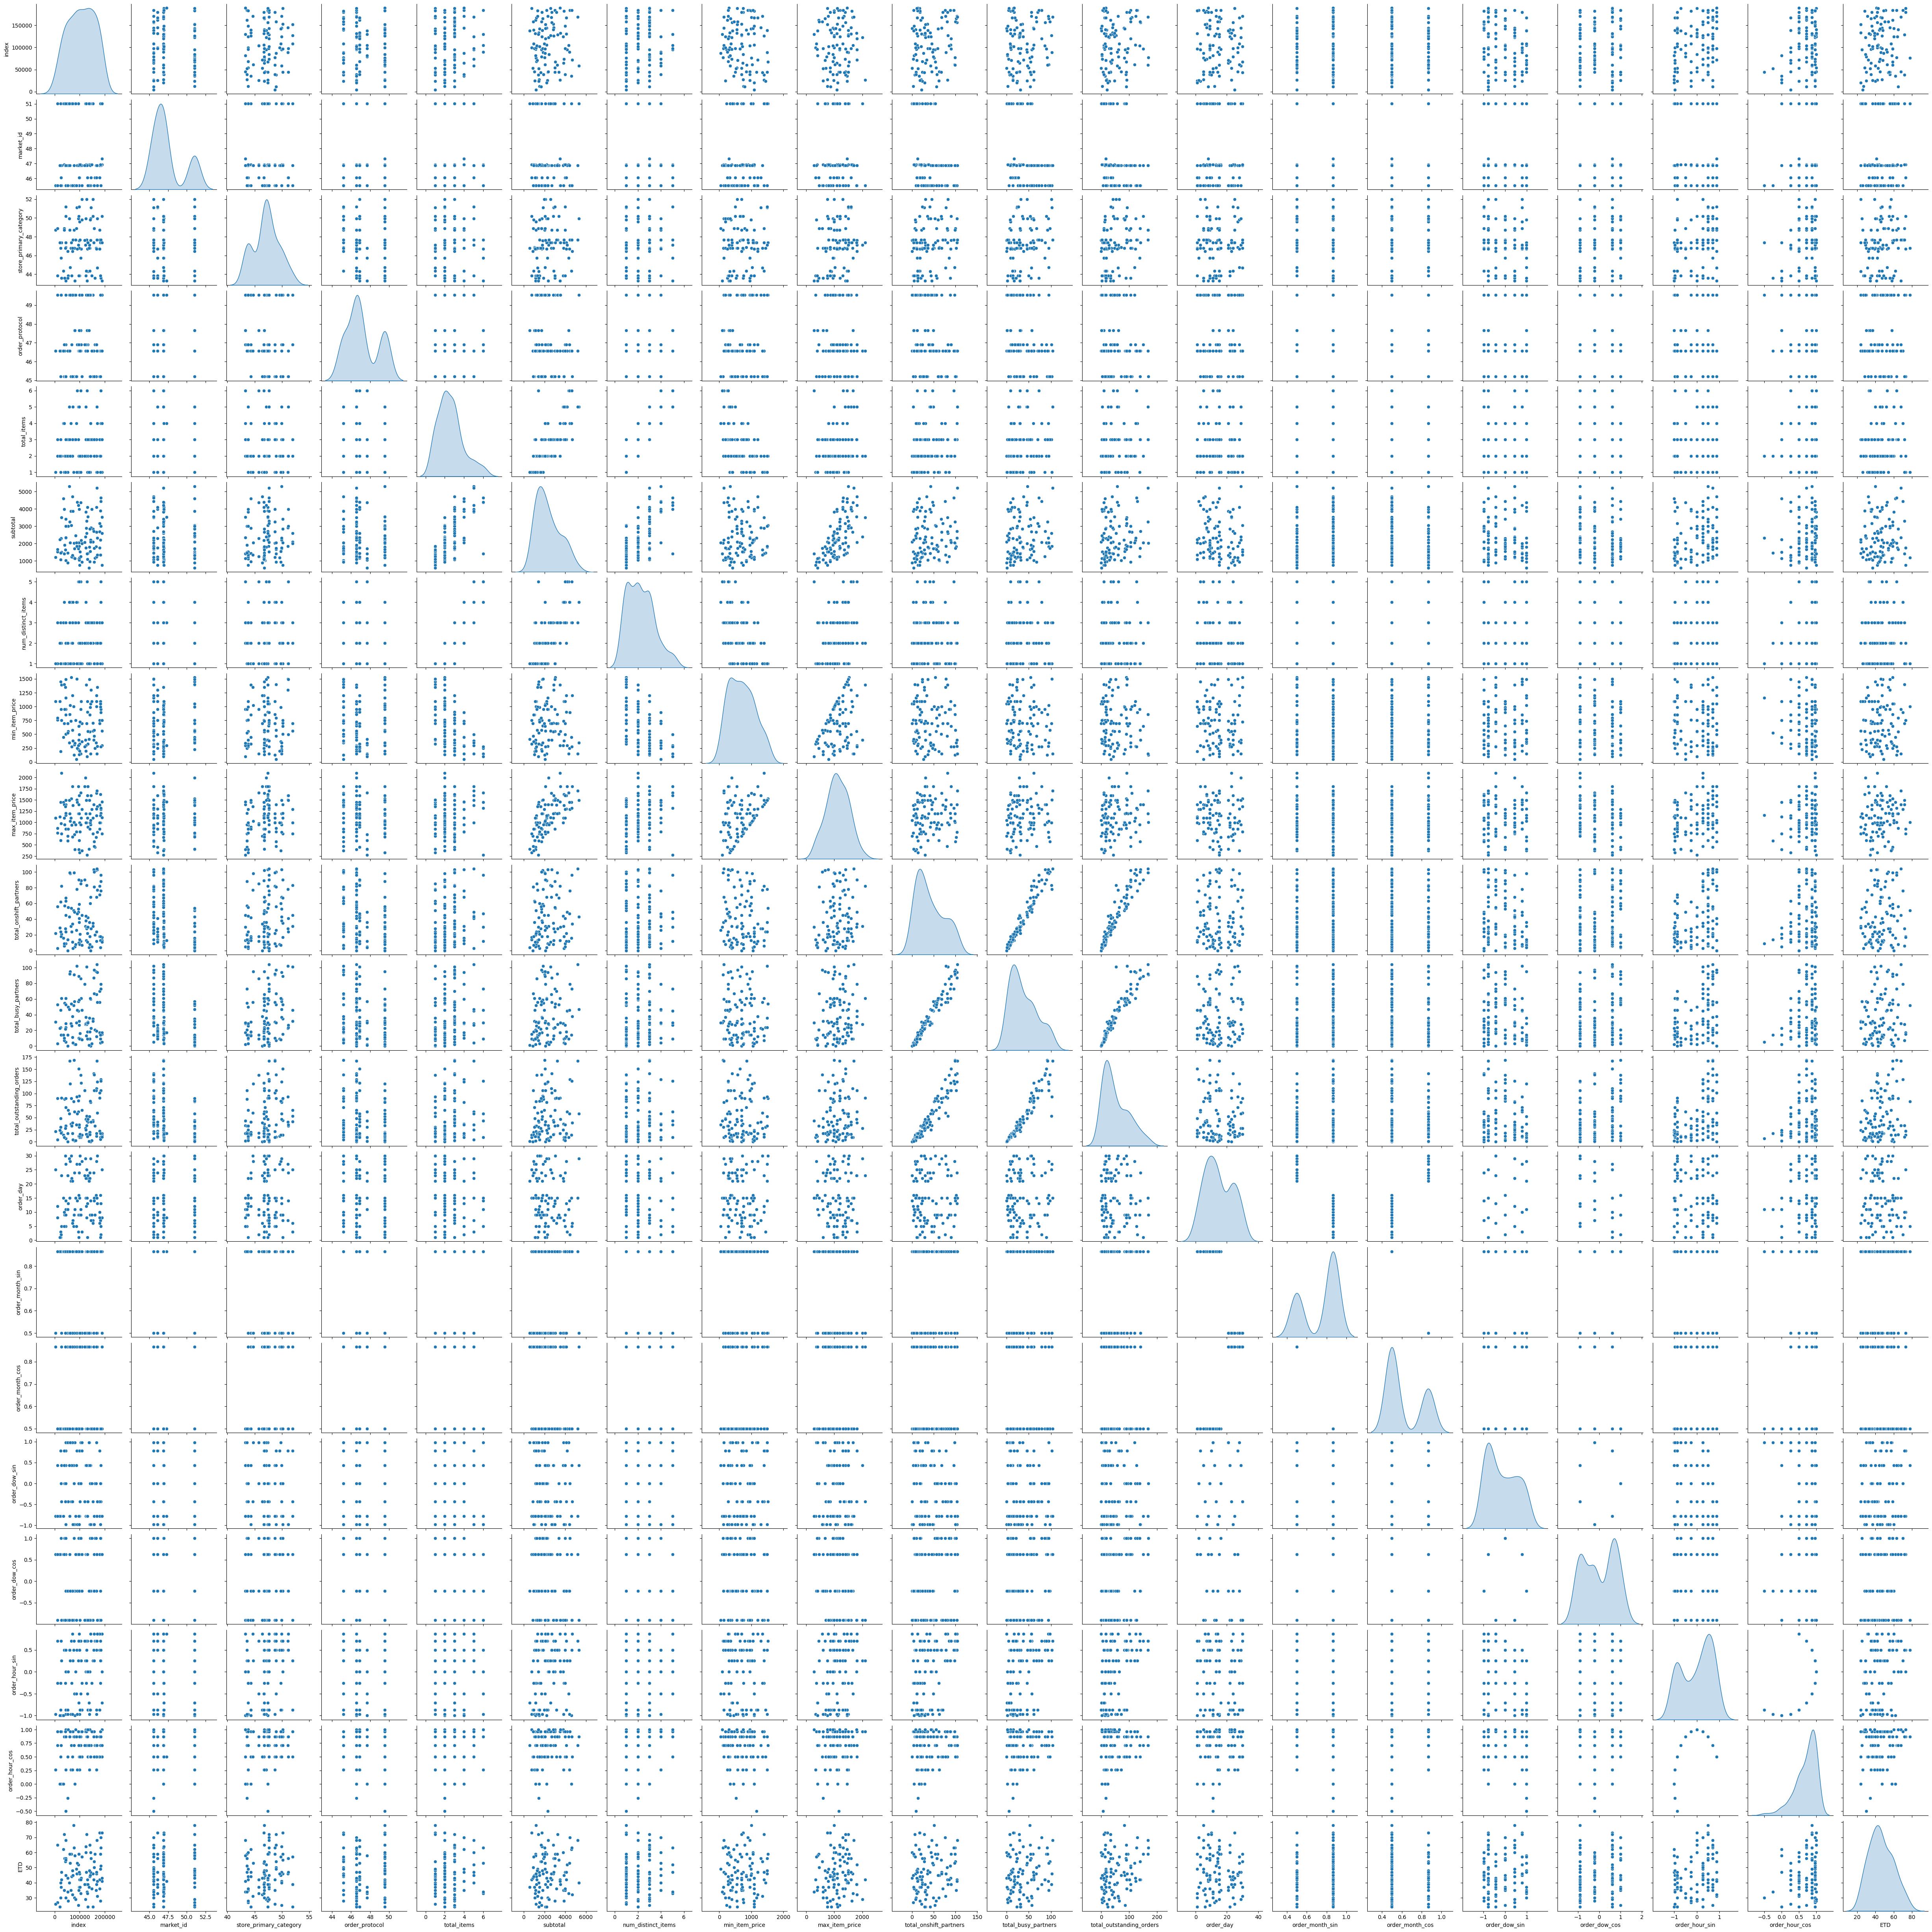

In [19]:
sample_dataset = dataset.sample(n=100, random_state=42)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    sns.pairplot(sample_dataset.drop(columns=['timestamp']), diag_kind='kde')

<Axes: >

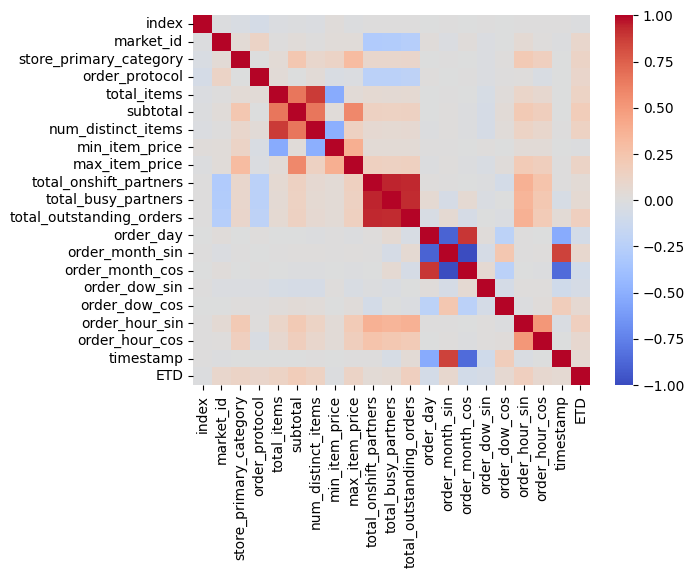

In [20]:
sns.heatmap(dataset.corr(), cmap='coolwarm')

# Esto nos indica que probablemente no hay buenas relaciones lineales entre ETD 
# y sus variables predictoras.

Let's also check the overall statistics. Note how each feature covers a very different range:

In [21]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,91482.0,9.958980e+04,56701.541065,0.000000e+00,5.128925e+04,1.002540e+05,1.488800e+05,1.974270e+05
market_id,91482.0,4.730918e+01,2.026029,4.554258e+01,4.554258e+01,4.687105e+01,4.694010e+01,5.101234e+01
store_primary_category,91482.0,4.705187e+01,2.453326,4.103922e+01,4.471946e+01,4.738270e+01,4.889400e+01,5.198969e+01
order_protocol,91482.0,4.721206e+01,1.615077,4.089474e+01,4.656242e+01,4.656242e+01,4.954073e+01,4.954073e+01
total_items,91482.0,2.776098e+00,1.463492,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,7.000000e+00
subtotal,91482.0,2.270165e+03,1227.019864,0.000000e+00,1.299000e+03,2.000000e+03,2.990000e+03,6.250000e+03
num_distinct_items,91482.0,2.443125e+00,1.225303,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
min_item_price,91482.0,6.224713e+02,367.148724,-8.600000e+01,3.000000e+02,5.950000e+02,8.950000e+02,1.579000e+03
max_item_price,91482.0,1.035785e+03,363.255769,0.000000e+00,7.950000e+02,9.990000e+02,1.295000e+03,2.100000e+03
total_onshift_partners,91482.0,3.889815e+01,27.766265,-4.000000e+00,1.600000e+01,3.300000e+01,5.700000e+01,1.150000e+02


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [22]:
X_train = train_dataset.drop(columns = ['ETD'])
X_test = test_dataset.drop(columns = ['ETD'])

y_train = train_dataset['ETD']
y_test = test_dataset['ETD']

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [23]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
index,9.958980e+04,56701.541065
market_id,4.730918e+01,2.026029
store_primary_category,4.705187e+01,2.453326
order_protocol,4.721206e+01,1.615077
total_items,2.776098e+00,1.463492
subtotal,2.270165e+03,1227.019864
num_distinct_items,2.443125e+00,1.225303
min_item_price,6.224713e+02,367.148724
max_item_price,1.035785e+03,363.255769
total_onshift_partners,3.889815e+01,27.766265


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [24]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [25]:
normalizer.adapt(np.array(X_train))

Calculate the mean and variance, and store them in the layer:

In [26]:
print(normalizer.mean.numpy())

[[ 9.959e+04  4.731e+01  4.705e+01  4.721e+01  2.776e+00  2.270e+03
   2.443e+00  6.225e+02  1.036e+03  3.890e+01  3.655e+01  4.819e+01
   1.467e+01  7.372e-01  6.288e-01 -5.299e-02 -1.464e-02 -6.420e-02
   6.706e-01  1.423e+09]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [27]:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 7.65e+04  5.10e+01  4.68e+01  4.95e+01  1.00e+00  1.18e+03  1.00e+00
   1.00e+03  1.00e+03  5.10e+01  5.20e+01  8.30e+01  5.00e+00  8.66e-01
   5.00e-01  4.34e-01 -9.01e-01  5.00e-01  8.66e-01  1.42e+09]]

Normalized: [[-0.41  1.83 -0.11  1.44 -1.21 -0.89 -1.18  1.03 -0.1   0.44  0.58  0.87
  -1.06  0.74 -0.74  0.71 -1.23  0.86  0.58  0.12]]


## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable

Begin with a single-variable linear regression to predict `'ETD'` from `'Total Outstanding Orders'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in your single-variable linear regression model:

- Normalize the `'Total Outstanding Orders'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'Total Outstanding Orders'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `Total Outstanding Orders` data:

In [28]:
total_outstanding_orders = np.array(X_train['total_outstanding_orders'])

total_outstanding_orders_normalizer = layers.Normalization(input_shape=[1,], axis=None)
total_outstanding_orders_normalizer.adapt(total_outstanding_orders)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Build the Keras Sequential model:

In [29]:
total_outstanding_orders_model = tf.keras.Sequential([
    total_outstanding_orders_normalizer,
    layers.Dense(units=1)
])

total_outstanding_orders_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

This model will predict `'ETD'` from `'total_outstanding_orders'`.

Run the untrained model on the first 10 'total_outstanding_orders' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [30]:
total_outstanding_orders_model.predict(total_outstanding_orders[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


array([[ 1.313],
       [-1.554],
       [-0.762],
       [-1.064],
       [-0.158],
       [-1.214],
       [-0.234],
       [-0.271],
       [-1.479],
       [-0.988]], dtype=float32)

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [31]:
total_outstanding_orders_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mse', metrics=['mae','r2_score'])

Use Keras `Model.fit` to execute the training for 100 epochs:

In [32]:
%%time
history = total_outstanding_orders_model.fit(
    X_train['total_outstanding_orders'],
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 641.0943 - mae: 19.9499 - r2_score: -2.5284 - val_loss: 186.2709 - val_mae: 11.0460 - val_r2_score: 0.0229
Epoch 2/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 181.6267 - mae: 10.8594 - r2_score: 0.0238 - val_loss: 186.5313 - val_mae: 11.0869 - val_r2_score: 0.0216
Epoch 3/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 182.4784 - mae: 10.8691 - r2_score: 0.0251 - val_loss: 186.2171 - val_mae: 11.0257 - val_r2_score: 0.0232
Epoch 4/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 182.5405 - mae: 10.8583 - r2_score: 0.0256 - val_loss: 186.3148 - val_mae: 11.0481 - val_r2_score: 0.0227
Epoch 5/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 183.8079 - mae: 10.8970 - r2_score: 0.0251 - val_loss: 186.2532 - val_mae: 11.0472 - val_r2_score: 0.0230
Epoch 6/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 182.7382 - mae: 10.8716 - r2_score: 0.0256 - val_loss: 186.4171 - val_mae: 11.0659 - val_r2

Visualize the model's training progress using the stats stored in the `history` object:

In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,r2_score,val_loss,val_mae,val_r2_score,epoch
95,182.599625,10.870517,0.024986,186.405746,11.023448,0.022241,95
96,182.547928,10.870136,0.025267,186.224152,11.021703,0.023194,96
97,182.578339,10.869424,0.025104,186.691620,11.039582,0.020742,97
98,182.636505,10.870911,0.024773,186.363571,11.067029,0.022462,98
99,182.566010,10.869249,0.025165,186.353256,11.002817,0.022516,99


In [34]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [ETD]')
    plt.legend()
    plt.grid(True)

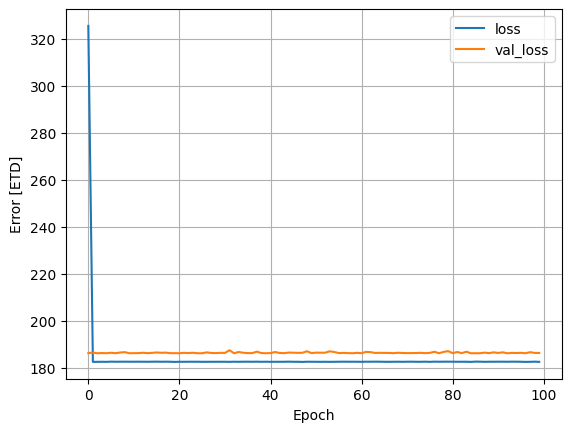

In [35]:
plot_loss(history)

Collect the results on the test set for later:

In [36]:
test_results = {}

In [37]:
test_results['total_outstanding_orders_model'] = total_outstanding_orders_model.evaluate(
    X_test['total_outstanding_orders'],
    y_test, verbose=1)

715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 184.9585 - mae: 10.9227 - r2_score: 0.0235


Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [38]:
x_reg = np.array(tf.linspace(np.min(X_train['total_outstanding_orders']), np.max(X_train['total_outstanding_orders']), 251)).reshape(-1, 1)
y_reg = total_outstanding_orders_model.predict(x_reg)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [39]:
def plot_total_outstanding_orders(x_reg, y_reg):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        sns.set_theme(style="dark")

        x, y = X_train['total_outstanding_orders'], y_train
        # Draw a combo histogram and scatterplot with density contours
        f, ax = plt.subplots(figsize=(6, 6))
        sns.scatterplot(x=x, y=y, s=5, color=".15")
        sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
        sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

        plt.plot(x_reg, y_reg, color='red', label='Predictions')
        plt.xlabel('Total Outstanding Orders')
        plt.ylabel('ETD')
        plt.legend()

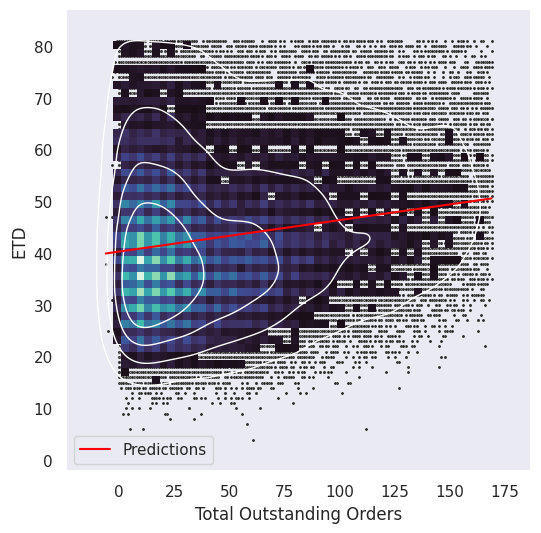

In [40]:
plot_total_outstanding_orders(x_reg, y_reg)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $x$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [41]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [42]:
linear_model.predict(X_train[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


array([[-0.62 ],
       [ 0.239],
       [-1.326],
       [-0.272],
       [ 0.748],
       [ 1.943],
       [ 0.585],
       [-0.897],
       [ 1.961],
       [ 1.811]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [43]:
linear_model.layers[1].kernel

<KerasVariable shape=(20, 1), dtype=float32, path=sequential_1/dense_1/kernel>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [44]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mse', metrics = ['mae','r2_score'])

In [45]:
%%time
history = linear_model.fit(
    X_train,
    y_train,
    epochs=100,
    # Suppress logging. 
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 638.7729 - mae: 19.7043 - r2_score: -2.4063 - val_loss: 157.7397 - val_mae: 10.0584 - val_r2_score: 0.1726
Epoch 2/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 155.8165 - mae: 9.9905 - r2_score: 0.1687 - val_loss: 157.8626 - val_mae: 10.0705 - val_r2_score: 0.1720
Epoch 3/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 155.9885 - mae: 10.0004 - r2_score: 0.1686 - val_loss: 158.1781 - val_mae: 10.0956 - val_r2_score: 0.1703
Epoch 4/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 155.1740 - mae: 9.9429 - r2_score: 0.1665 - val_loss: 159.3221 - val_mae: 10.0797 - val_r2_score: 0.1643
Epoch 5/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 154.5219 - mae: 9.9277 - r2_score: 0.1712 - val_loss: 157.8070 - val_mae: 10.0727 - val_r2_score: 0.1723
Epoch 6/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 155.8610 - mae: 9.9724 - r2_score: 0.1657 - val_loss: 158.2815 - val_mae: 10.0153 - val_r2_sco

Using all the inputs in this regression model achieves a much lower training and validation error than the `Total Outstanding Orders`, which had one input:

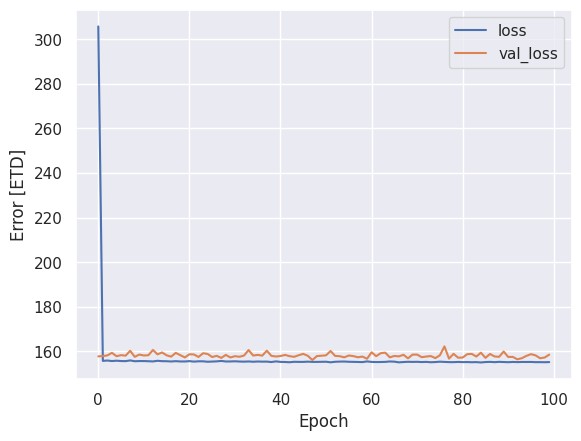

In [46]:
plot_loss(history)

Collect the results on the test set for later:

In [47]:
test_results['linear_model'] = linear_model.evaluate(
    X_test, y_test, verbose=1)

715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 157.1981 - mae: 10.0630 - r2_score: 0.1699


## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `total_outstanding_orders` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

### Regression using a DNN and a single input

In [48]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae','r2_score'])
    return model

Create a DNN model with only `'total_outstanding_orders'` as input and `total_outstanding_orders_normalizer` (defined earlier) as the normalization layer:

In [49]:
dnn_total_outstanding_orders_model = build_and_compile_model(total_outstanding_orders_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [50]:
dnn_total_outstanding_orders_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Train the model with Keras `Model.fit`:

In [51]:
%%time
history = dnn_total_outstanding_orders_model.fit(
    X_train['total_outstanding_orders'],
    y_train,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 548.7285 - mae: 17.5902 - r2_score: -1.9160 - val_loss: 184.9305 - val_mae: 10.9606 - val_r2_score: 0.0300
Epoch 2/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 181.4010 - mae: 10.8298 - r2_score: 0.0315 - val_loss: 185.3497 - val_mae: 10.9666 - val_r2_score: 0.0278
Epoch 3/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 182.0544 - mae: 10.8509 - r2_score: 0.0343 - val_loss: 185.9369 - val_mae: 10.8941 - val_r2_score: 0.0247
Epoch 4/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 181.2987 - mae: 10.8233 - r2_score: 0.0339 - val_loss: 186.5544 - val_mae: 10.8856 - val_r2_score: 0.0215
Epoch 5/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 181.9629 - mae: 10.8439 - r2_score: 0.0312 - val_loss: 184.6190 - val_mae: 10.9988 - val_r2_score: 0.0316
Epoch 6/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 181.9877 - mae: 10.8393 - r2_score: 0.0297 - val_loss: 185.5499 - val_mae: 11.0859 - val_r2

This model does slightly better than the linear single-input `total_outstanding_orders_model`:

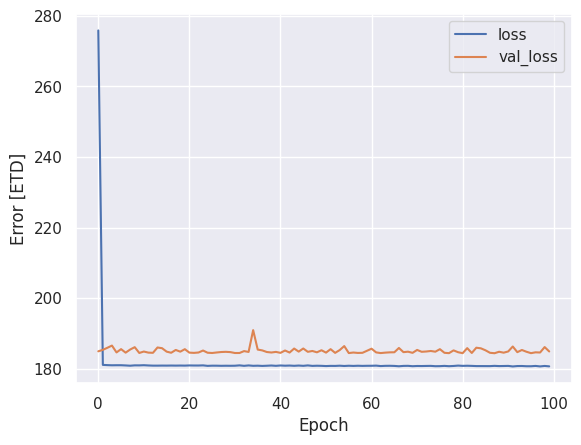

In [52]:
plot_loss(history)

If you plot the predictions as a function of `'Total Outstanding Orders'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [53]:
x_reg = np.array(tf.linspace(np.min(X_train['total_outstanding_orders']), np.max(X_train['total_outstanding_orders']), 251)).reshape(-1,1)
y_reg = dnn_total_outstanding_orders_model.predict(x_reg)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


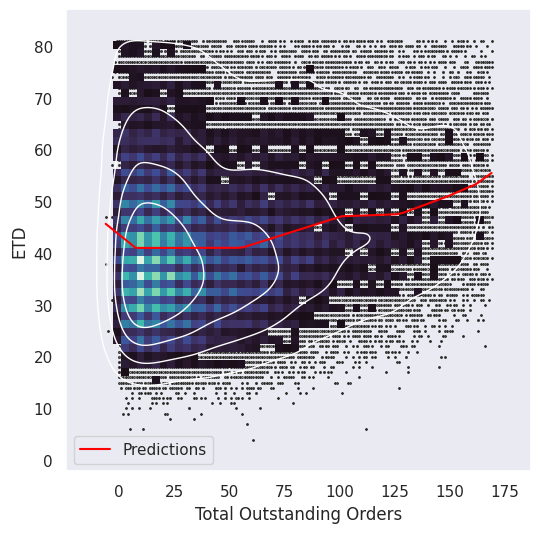

In [54]:
plot_total_outstanding_orders(x_reg, y_reg)

Collect the results on the test set for later:

In [55]:
test_results['dnn_total_outstanding_orders_model'] = dnn_total_outstanding_orders_model.evaluate(
    X_test['total_outstanding_orders'], y_test,
    verbose=1)

715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 183.4773 - mae: 10.8369 - r2_score: 0.0314


### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [56]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 20)               │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (168.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 41 (168.00 B)

In [57]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 406.0795 - mae: 14.9365 - r2_score: -1.1678 - val_loss: 156.3476 - val_mae: 10.0338 - val_r2_score: 0.1799
Epoch 2/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 152.5931 - mae: 9.8682 - r2_score: 0.1842 - val_loss: 154.4013 - val_mae: 9.9964 - val_r2_score: 0.1901
Epoch 3/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 151.5441 - mae: 9.8384 - r2_score: 0.1982 - val_loss: 152.5680 - val_mae: 9.8257 - val_r2_score: 0.1997
Epoch 4/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 148.6021 - mae: 9.7270 - r2_score: 0.2033 - val_loss: 150.5834 - val_mae: 9.7995 - val_r2_score: 0.2101
Epoch 5/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 147.8287 - mae: 9.6988 - r2_score: 0.2157 - val_loss: 152.0833 - val_mae: 9.9534 - val_r2_score: 0.2023
Epoch 6/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 146.4074 - mae: 9.6385 - r2_score: 0.2120 - val_loss: 150.5573 - val_mae: 9.7091 - val_r2_score: 0.

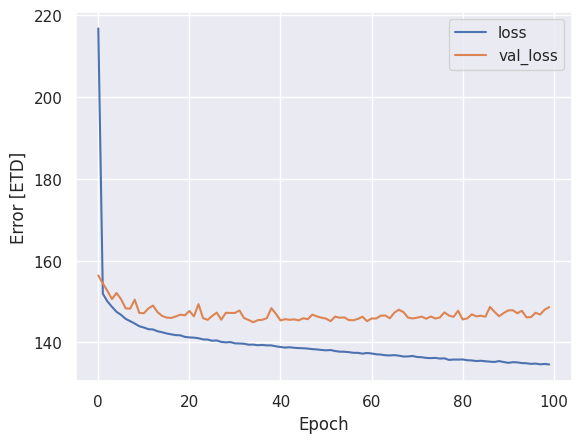

In [58]:
plot_loss(history)

Collect the results on the test set:

In [59]:
test_results['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=1)

715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 148.6349 - mae: 9.6737 - r2_score: 0.2151


## Regression using a DNN: Raúl

In [60]:
def dnn_raul_pipeline(norm):
    model = keras.Sequential([
        norm,
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1)
    ])

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae','r2_score'])
    return model

In [61]:
dnn_raul = dnn_raul_pipeline(normalizer)
dnn_raul.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 20)             │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (168.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 41 (168.00 B)

In [62]:
history = dnn_raul.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=1,
    batch_size=1024,
    epochs=100
)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1775.0354 - mae: 39.5319 - r2_score: -8.5134 - val_loss: 364.0128 - val_mae: 14.9662 - val_r2_score: -0.9084
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 270.2517 - mae: 12.8981 - r2_score: -0.4362 - val_loss: 189.3158 - val_mae: 10.9531 - val_r2_score: 0.0080
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 207.2101 - mae: 11.4193 - r2_score: -0.1037 - val_loss: 176.9292 - val_mae: 10.6004 - val_r2_score: 0.0730
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 197.7371 - mae: 11.1361 - r2_score: -0.0603 - val_loss: 169.8826 - val_mae: 10.3950 - val_r2_score: 0.1099
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 190.0028 - mae: 10.9698 - r2_score: -0.0161 - val_loss: 165.1400 - val_mae: 10.2730 - val_r2_score: 0.1348
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 186.5952 - mae: 10.8584 - r2_score: 0.0110 - val_loss: 162.0744 - val_mae: 10.1484 - val_r2_score: 0.1509
Ep

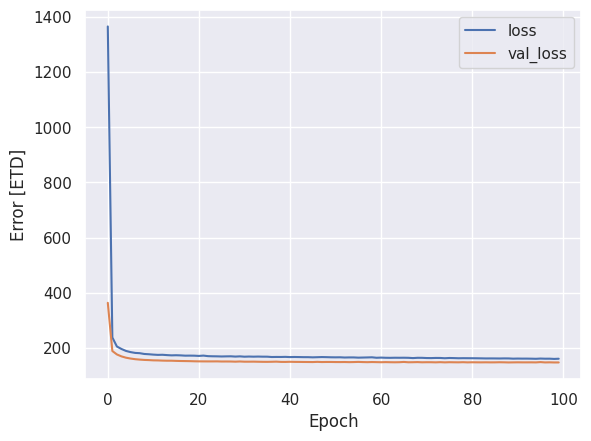

In [63]:
plot_loss(history)

In [64]:
test_results['dnn_raul'] = dnn_raul.evaluate(X_test, y_test, verbose=1)

715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 147.2186 - mae: 9.6492 - r2_score: 0.2234


## Performance

Since all models have been trained, you can review their test set performance:

In [65]:
test_results

{'total_outstanding_orders_model': [182.78932189941406,
  10.879587173461914,
  0.027316391468048096],
 'linear_model': [156.0434112548828, 10.005763053894043, 0.1696404218673706],
 'dnn_total_outstanding_orders_model': [181.14364624023438,
  10.78531551361084,
  0.03607362508773804],
 'dnn_model': [146.47454833984375, 9.604241371154785, 0.22055953741073608],
 'dnn_raul': [145.3064422607422, 9.599349021911621, 0.22754645347595215]}

In [77]:
results_df = pd.DataFrame(test_results, index=['MSE', 'MAE', 'R2']).T
results_df['RMSE'] = np.sqrt(results_df['MSE'])
results_df

,MSE,MAE,R2,RMSE
total_outstanding_orders_model,182.789322,10.879587,0.027316,13.519960
linear_model,156.043411,10.005763,0.169640,12.491734
dnn_total_outstanding_orders_model,181.143646,10.785316,0.036074,13.458962
dnn_model,146.474548,9.604241,0.220560,12.102667
dnn_raul,145.306442,9.599349,0.227546,12.054312


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

In [78]:
y_pred = np.array(dnn_raul.predict(X_test)).T[0]

715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(22871,)
(22871,)


<Figure size 800x800 with 0 Axes>

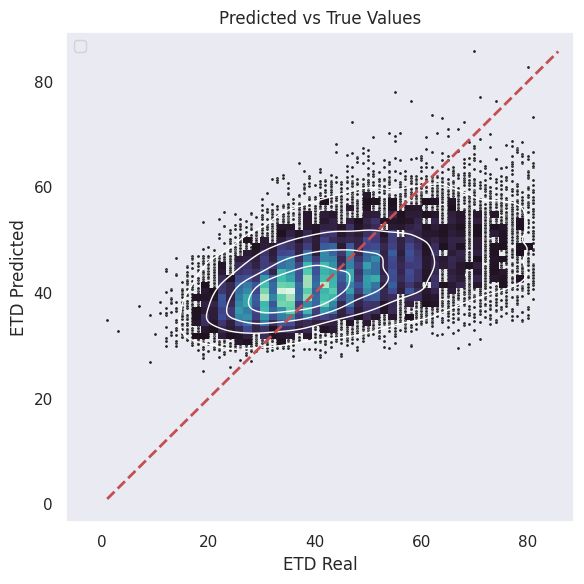

In [79]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    sns.set_theme(style="dark")
    plt.figure(figsize=(8, 8))  # Create a square figure
    x, y = y_test, y_pred
    print(x.shape)
    print(y.shape)
    # Draw a combo histogram and scatterplot with density contours
    f, ax = plt.subplots(figsize=(6, 6))
    sns.scatterplot(x=x, y=y, s=5, color=".15")
    sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
    sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)
    
    # Add a diagonal line representing perfect predictions
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    plt.xlabel('ETD Real')
    plt.ylabel('ETD Predicted')
    plt.title('Predicted vs True Values')
    plt.legend()

    plt.tight_layout()
    plt.show()

It appears that the model predicts reasonably well.

Now, check the error distribution:

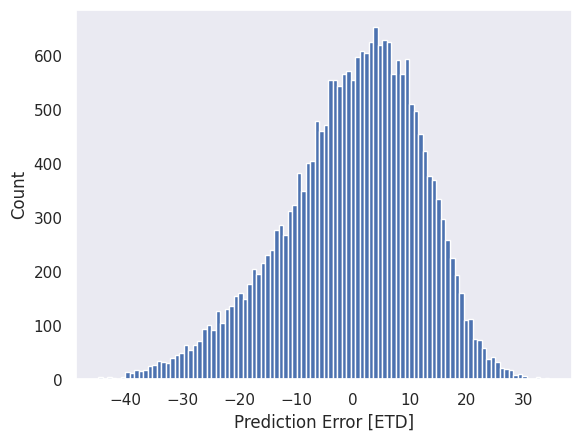

In [80]:
error = y_pred - y_test
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [ETD]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [81]:
dnn_raul.save('dnn_model.keras')

If you reload the model, it gives identical output:

## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.

En este notebook hice bastantes modificaciones, especialmente porque la predicción utilizando el tiempo como variable predictora es de gran interés mío. Escogí un dataset en Kaggle el cual tenga la intención de predicción de la hora de entrega de un pedido en India. Se tuvo que agregar una sección de preprocesamiento en la que se hizo aumentación de los datos, aplicando transformaciones sinusoidales en variables cíclicas. Adicionalmente, se optó por utilizar un tipo de encoding que nunca había explorado antes, el Target Encoding, que es remplazar las variables categóricas con la media de la variable predictora para esa categoria. Se decidió permanecer hasta el percentil 95% en todas las variables, debido al sesgo que se presentaba al probar con distintos modelos por los puntos atípicos. Decidí dejar los modelos originales propuestos para el dataset original (la versión que se tiene de este notebook inédita). Esto se decidió con el fin de probar como funcionarían estos modelos en un dataset distinto, haciendo leves modificaciones para adaptarse al contexto del problema. Al final, decidí agregar mi propia versión de la red neuronal profunda. Probé con distintas arquitecturas. Viendo que con dos capas ocultas de 64 nodos cada una tuvo buenos resultados, decidí primero probar agregando otra capa con el mismo número de nodos. Sin embargo, la gráfica de val_loss vs epocas mostraba que convergía pronto, mientras que la gráfica de loss en training seguía disminuyendo mientras incrementaban las épocas. Esto me hizo sospechar overfitting, por lo que decidí probar con menos capas ocultas. De ahí experimenté con varios tamaños de nodos, concluyendo que el mejor modelo tenía una capa oculta de 256 nodos. Este modelo funcionó levemente mejor, con lo que se puede decir que las ediciones fueron satisfactorias. Probé distintos hiperparámetros, como la tasa de aprendizaje y los batch sizes. Por último, concluyo que esta estructura (una DNN) no es la mejor estructura para predicción de tiempo, debido a que incluso y las estructuras más simples pueden hacer overfitting de los datos. Esto me hace pensar que o hace falta más información (a través de aumentación de los datos o de más variables con relación al tiempo) o la estructura de la red no es ideal. Una breve investigación de modelos me dice que podría intentar una LSTM Neural Network como otra opción. Sin embargo, intentar ese camino quedaría como un extra para proyectos futuros.